In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import SobolIndices, SobolKrigingIndices
from shapley.tests import Ishigami
from shapley.tests.test_functions import AdditiveGaussian
from shapley.plots import set_style_paper, plot_sensitivity_results

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = False
ylim = [0., 1.]

## The Model

In [2]:
dim = 3
beta = [1., 1., 1.]
gaussian = AdditiveGaussian(dim=dim, beta=beta)
model = gaussian

theta_12 = -0.5
theta_13 = 0.2
theta_23 = -0.7
sigma = np.identity(dim)
sigma[1, 0] = theta_12
sigma[0, 1] = theta_12
sigma[2, 0] = theta_13
sigma[0, 2] = theta_13
sigma[2, 1] = theta_23
sigma[1, 2] = theta_23

copula = ot.NormalCopula(ot.CorrelationMatrix(sigma))
model.copula = copula

In [3]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_sample = 1000

# Evaluate the model
sobol = SobolIndices(model.input_distribution)
sobol.build_uncorrelated_mc_sample(model, n_sample)

In [8]:
n_boot = 500
estimator = 'soboleff2'
sobol_results_full = sobol.compute_full_indices(n_boot=n_boot, estimator=estimator)
sobol_results_ind = sobol.compute_ind_indices(n_boot=n_boot, estimator=estimator)

# Results
first_indices_full_mc = sobol_results_full.first_indices
total_indices_full_mc = sobol_results_full.total_indices
first_indices_ind_mc = sobol_results_ind.first_indices
total_indices_ind_mc = sobol_results_ind.total_indices

print("Full Sobol indices:", first_indices_full_mc)
print("Full Total Sobol indices:", first_indices_full_mc)
print("Ind Sobol indices:", first_indices_ind_mc)
print("Ind Total Sobol indices:", first_indices_ind_mc)

Full Sobol indices: [ 0.46654437  0.02649501  0.20256127]
Full Total Sobol indices: [ 0.46654437  0.02649501  0.20256127]
Ind Sobol indices: [ 0.69036115  0.37218582  0.4861528 ]
Ind Total Sobol indices: [ 0.69036115  0.37218582  0.4861528 ]


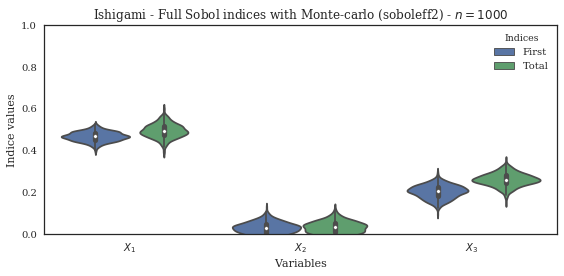

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_results_full, ax=ax)
ax.set_title("Ishigami - Full Sobol indices with Monte-carlo (%s) - $n=%d$" % (estimator, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_sobol_MC.pdf')

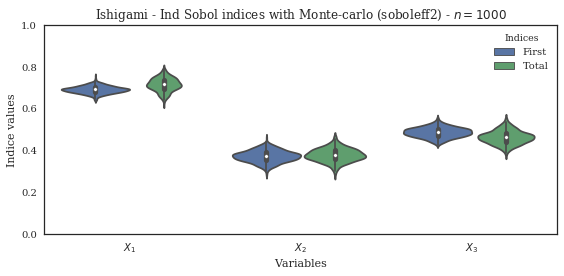

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_results_ind, ax=ax)
ax.set_title("Ishigami - Ind Sobol indices with Monte-carlo (%s) - $n=%d$" % (estimator, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_sobol_MC.pdf')

## Using a Kriging model to substitute the true model

### Building the model

In [36]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
model_budget = 50
basis = 'quadratic'
kernel = 'matern'
library = 'sklearn'
sampling = 'monte-carlo'
sobol_kriging = SobolKrigingIndices(model.input_distribution)
meta_model = sobol_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel, library=library, sampling=sampling)

### The quality of the kriging model

#### With Leave One Out

In [37]:
score_q2_loo = meta_model.compute_score_q2_loo()
print('Leave One Out Q2 score:', score_q2_loo)

C:\Users\naz-probook\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -9.00936977e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Leave One Out Q2 score: 0.997245630349


#### With cross validation

In [38]:
n_sample_cv = 1000
score_q2_cv = meta_model.compute_score_q2_cv(n_sample_cv, sampling='monte-carlo')
print('Cross Validation Q2 score with %d observations:' % (n_sample_cv), score_q2_cv)

Cross Validation Q2 score with 1000 observations: 0.996260188637


### Estimating the indices

In [39]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
n_sample = 500
n_realization = 300

# Evaluate the kriging model
sobol_kriging.build_uncorrelated_mc_sample(meta_model, n_sample, n_realization)

Wall time: 10.1 s


In [40]:
%%time
n_boot = 500
estimator = 'soboleff2'
sobol_kriging_results_full = sobol_kriging.compute_full_indices(n_boot=n_boot, estimator=estimator)
sobol_kriging_results_ind = sobol_kriging.compute_ind_indices(n_boot=n_boot, estimator=estimator)

# Results
first_indices_full_gp = sobol_kriging_results_full.first_indices
total_indices_full_gp = sobol_kriging_results_full.total_indices
first_indices_ind_gp = sobol_kriging_results_ind.first_indices
total_indices_ind_gp = sobol_kriging_results_ind.total_indices

print("Full Sobol indices:", first_indices_full_gp)
print("Full Total Sobol indices:", first_indices_full_gp)
print("Ind Sobol indices:", first_indices_ind_gp)
print("Ind Total Sobol indices:", first_indices_ind_gp)

Full Sobol indices: [ 0.5135805   0.0719514   0.25512417]
Full Total Sobol indices: [ 0.5135805   0.0719514   0.25512417]
Ind Sobol indices: [ 0.683047    0.41420805  0.51055288]
Ind Total Sobol indices: [ 0.683047    0.41420805  0.51055288]
Wall time: 25.3 s


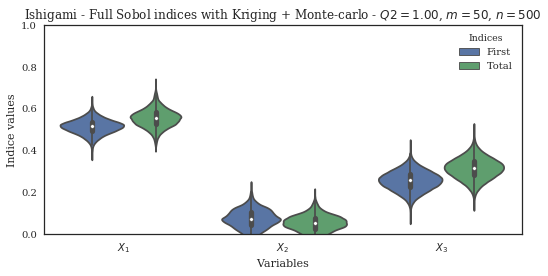

In [41]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_kriging_results_full, indice='both', ax=ax)
ax.set_title("Ishigami - Full Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))

ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_sobol_MC.pdf')

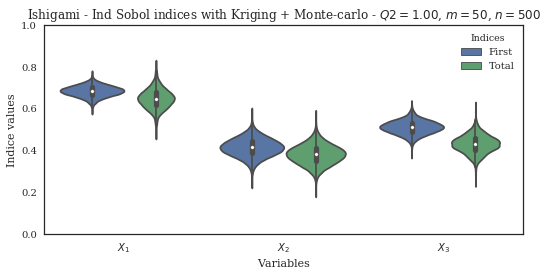

In [42]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_kriging_results_ind, indice='both', ax=ax)
ax.set_title("Ishigami - Ind Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_sobol_MC.pdf')

#### Plots of the first indices with the kriging and monte-carlo errors

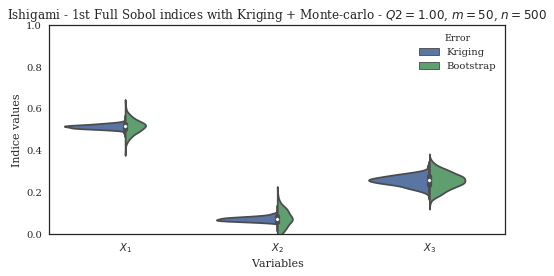

In [43]:
fig, ax = plt.subplots(figsize=(8, 4))
aa = plot_sensitivity_results(sobol_kriging_results_full, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_title("Ishigami - 1st Full Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_1st_sobol_GP.pdf')

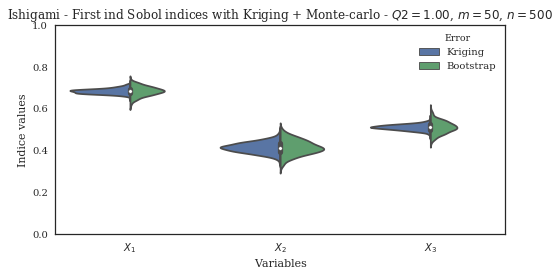

In [44]:
fig, ax = plt.subplots(figsize=(8, 4))
aa = plot_sensitivity_results(sobol_kriging_results_ind, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_title("Ishigami - First ind Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_total_sobol_GP.pdf')